## Imports and Initialize Models

In [29]:
from watermarkers.SemStamp.sbert_lsh_model import *
from nltk import sent_tokenize
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from sentence_transformers import SentenceTransformer
from transformers import AutoModel, AutoTokenizer

# embedder = SentenceTransformer("sentence-transformers/all-mpnet-base-v1")
# embedder.eval()
import torch
class CustomSentenceTransformer:
    def __init__(self, model_name):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)

    def encode(self, sentences, batch_size=1, convert_to_tensor=False):
        embeddings = []
        for sentence in sentences:
            inputs = self.tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)
            with torch.no_grad():
                outputs = self.model(**inputs)
            # Mean pooling to get the sentence embedding
            token_embeddings = outputs.last_hidden_state
            attention_mask = inputs.attention_mask
            input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
            sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
            sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
            sentence_embedding = sum_embeddings / sum_mask
            if convert_to_tensor:
                embeddings.append(sentence_embedding)
            else:
                embeddings.append(sentence_embedding.cpu().numpy())
        return embeddings if not convert_to_tensor else torch.stack(embeddings)

# Instantiate the custom transformer
model_name = 'AbeHou/SemStamp-c4-sbert'  # Replace with the correct model name
embedder = CustomSentenceTransformer(model_name)

# TODO: Fix lsh_model_path. We're using the default model in their code right now.
lsh_model = SBERTLSHModel(lsh_model_path=None,
                            device="cuda", batch_size=1, lsh_dim=3, sbert_type='base', embedder=embedder)

lsh_dim = 3
lmbd = 0.25

initializing random projection LSH model
loading SBERT base model...


In [30]:
def plot_embeddings_3d(embeddings, sentences, title):
    """
    Plots sentence embeddings in 3D.
    
    Parameters:
    embeddings (np.ndarray): Array containing the embeddings.
    sentences (list of str): List containing the sentences.
    title (str): Title for the plot.
    """
    x = embeddings[:, 0]
    y = embeddings[:, 1]
    z = embeddings[:, 2]

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the points as arrows originating from the origin (0,0,0)
    for i in range(len(x)):
        ax.quiver(0, 0, 0, x[i], y[i], z[i], arrow_length_ratio=0.1)

    # Annotate the points with the original sentences
    for i, sentence in enumerate(sentences):
        ax.text(x[i], y[i], z[i], sentence)

    ax.set_title(title)
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")
    ax.set_zlabel("Dimension 3")

    plt.show()

def plot_embedding_3d(embedding, sentence, title):
    """
    Plots sentence embeddings in 3D.
    
    Parameters:
    embeddings (np.ndarray): Array containing the embeddings.
    sentences (list of str): List containing the sentences.
    title (str): Title for the plot.
    """
    x = embedding[0]
    y = embedding[1]
    z = embedding[2]

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')


    ax.quiver(0, 0, 0, x, y, z, arrow_length_ratio=0.1)

    ax.text(x, y, z, sentence)

    ax.set_title(title)
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")
    ax.set_zlabel("Dimension 3")

    plt.show()

In [31]:
# df = pd.read_csv('semstamp_attacks/06_01_prompt_based_lotr_word.csv') # word-based
df = pd.read_csv('06_01_prompt_based_gpt.csv')
quality_preserved_df = df[df['quality_preserved'] == True]


original_text = df['current_text'].iloc[0]
mutated_text = quality_preserved_df['mutated_text'].iloc[-1]

In [32]:
print(f"Original Text\n\n {original_text}\n---\n")
print(f"Mutated Text\n \n {mutated_text}")

Original Text

 In J.R.R. Tolkien's esteemed Lord of the Rings series, power is a pervasive and profound theme that underscores the narrative's exploration of morality, toils, and triumphs. The struggle for power is a dominant force that drives the plot forward, propelling characters towards their destinies.

The primary embodiment of power in the series is, undoubtedly, the One Ring. Forged by the Dark Lord Sauron, this talismanic artifact represents the apex of dark power, corrupting all who come into contact with it. The Ring's insidious influence seduces even the strongest of wills, exemplified by Boromir's tragic fallibility. As the quest to destroy the Ring unfolds, the pernicious nature of power becomes increasingly apparent, its corrosive effects seeping into the very fabric of Middle-earth's social hierarchy.

Conversely, the free peoples of Middle-earth – including the Elves, Dwarves, and Humans – exemplify an alternative form of power: one rooted in wisdom, courage, and fell

In [33]:
test_sentence = "I am livid."
test_sents = sent_tokenize(test_sentence)
test_embeddings = np.stack(embedder.encode(test_sents, batch_size=1))
# test_embeddings = embedder.encode(test_sents)
# test_embeddings = np.squeeze(np.array(test_embeddings))
# print(test_embeddings)
plot_embeddings_3d(test_embeddings, test_sents, "Test Embeddings")

IndexError: index 1 is out of bounds for axis 1 with size 1

In [22]:
original_sents = sent_tokenize(original_text)
original_embeddings = np.stack(embedder.encode(original_sents, batch_size=1))

mutated_sents = sent_tokenize(mutated_text)
mutated_embeddings = np.stack(embedder.encode(mutated_sents, batch_size=1))

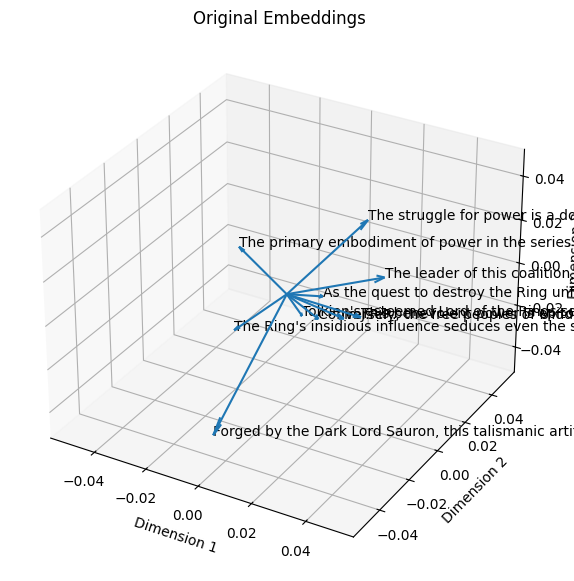

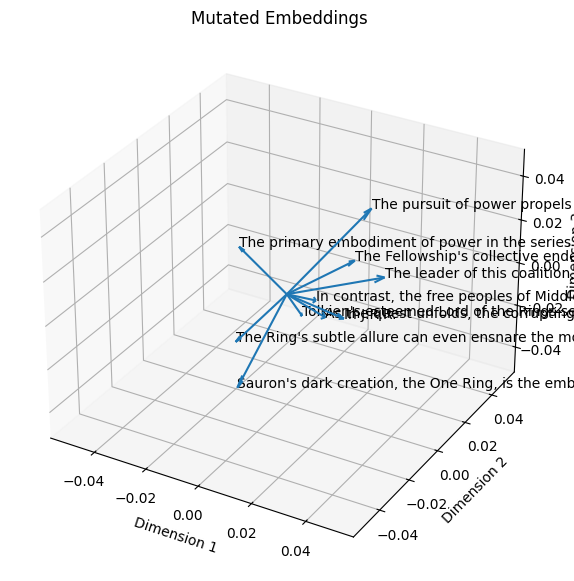

In [23]:
plot_embeddings_3d(original_embeddings, original_sents, "Original Embeddings")
plot_embeddings_3d(mutated_embeddings, mutated_sents, "Mutated Embeddings")


In [24]:
original_hash_ints = lsh_model.get_hash(original_sents)
print(f"Original Hash Integers: {original_hash_ints}")

mutated_hash_ints = lsh_model.get_hash(mutated_sents)
print(f"Mutated Hash Integers: {mutated_hash_ints}")

Original Hash Integers: [2, 5, 4, 7, 6, 0, 5, 1, 6, 0]
Mutated Hash Integers: [2, 5, 6, 7, 2, 0, 7, 5, 7, 0]


In [25]:
num_sentence = 2

sentence = original_sents[num_sentence]
sentence_embedding = np.stack(embedder.encode(sentence, batch_size=1))

mutated_sentence = mutated_sents[num_sentence]
mutated_sentence_embedding = np.stack(embedder.encode(mutated_sentence, batch_size=1))

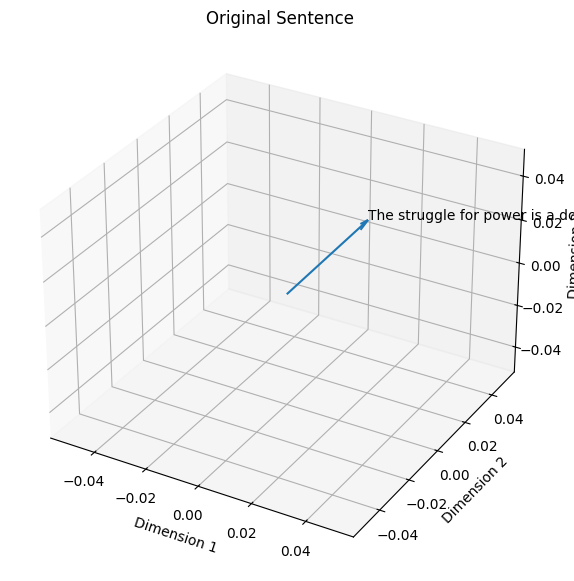

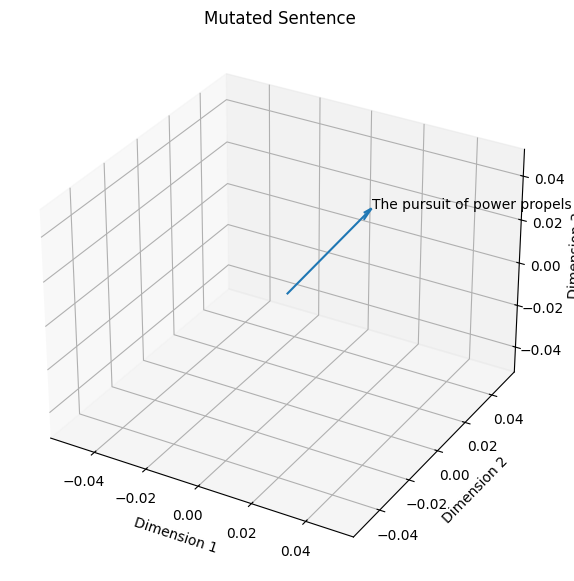

In [26]:
plot_embedding_3d(sentence_embedding, sentence, "Original Sentence")
plot_embedding_3d(mutated_sentence_embedding, mutated_sentence, "Mutated Sentence")

In [27]:
from watermarkers.SemStamp.sampling_lsh_utils import get_mask_from_seed
original_lsh_seed = lsh_model.get_hash([sentence])[0]
print(original_lsh_seed)
mutated_lsh_seed = lsh_model.get_hash([mutated_sentence])[0]
print(mutated_lsh_seed)

original_accept_mask = get_mask_from_seed(lsh_dim, lmbd, original_lsh_seed)
print(original_accept_mask)
mutated_accept_mask = get_mask_from_seed(lsh_dim, lmbd, mutated_lsh_seed)
print(mutated_accept_mask)

4
6
tensor([7, 2], device='cuda:0')
tensor([0, 3], device='cuda:0')


## Trash Can That Might Be Useful

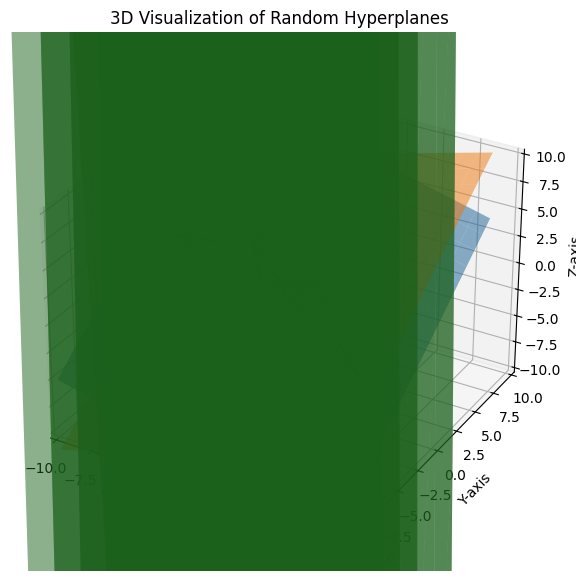

In [28]:

# Define a function to plot a plane given a normal vector and a point
def plot_plane(ax, normal_vector, point_on_plane, plane_label):
    d = -point_on_plane.dot(normal_vector)
    xx, yy = np.meshgrid(range(-10, 10), range(-10, 10))
    zz = (-normal_vector[0] * xx - normal_vector[1] * yy - d) * 1. /normal_vector[2]
    ax.plot_surface(xx, yy, zz, alpha=0.5)
    ax.quiver(0, 0, 0, normal_vector[0], normal_vector[1], normal_vector[2], length=10, color='r')
    ax.text(normal_vector[0], normal_vector[1], normal_vector[2], plane_label)

# Generate three random normal vectors for the hyperplanes
np.random.seed(1234)
normal_vectors = np.random.randn(3, 3)

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the hyperplanes
for i, normal_vector in enumerate(normal_vectors):
    plot_plane(ax, normal_vector, np.array([0, 0, 0]), f'Plane {i+1}')

ax.set_title("3D Visualization of Random Hyperplanes")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])
ax.set_zlim([-10, 10])
plt.show()